In [10]:
import numpy as np
# ^^^ pyforest auto-imports - don't write above this line
from keras.models import load_model
import matplotlib.pyplot as plt
from keras import models

In [2]:
model = load_model('cats_and_dogs_small.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [3]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [4]:
from keras.preprocessing import image

In [5]:
img_path = 'datasets/catndogs_small/test/cats/cat.1700.jpg'
img = image.load_img(img_path, target_size=(150, 150))

In [7]:
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255

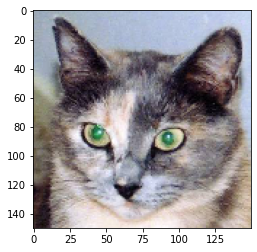

In [9]:
plt.imshow(img_tensor[0])
plt.show()

In [13]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(input = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

/home/akshat/Documents/GHrepos/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("co...)`
  


In [14]:
first_layer_activation = activations[0]
print(first_layer_activation)

[[[[0.         0.21770556 0.05177874 ... 0.         0.20336716
    0.        ]
   [0.         0.22006309 0.05051369 ... 0.         0.20294191
    0.        ]
   [0.         0.21658455 0.04442521 ... 0.         0.20208758
    0.        ]
   ...
   [0.         0.27753857 0.05997773 ... 0.         0.2447249
    0.        ]
   [0.         0.2860475  0.06328266 ... 0.         0.24866123
    0.        ]
   [0.         0.28694597 0.06183787 ... 0.         0.24953108
    0.        ]]

  [[0.         0.2123004  0.0483206  ... 0.         0.19546306
    0.        ]
   [0.         0.21451621 0.04767516 ... 0.         0.19594908
    0.        ]
   [0.         0.21103817 0.03844744 ... 0.         0.19450189
    0.        ]
   ...
   [0.         0.28158423 0.05700966 ... 0.         0.24861924
    0.        ]
   [0.         0.28546634 0.06576978 ... 0.         0.24842216
    0.        ]
   [0.         0.28966823 0.06755947 ... 0.         0.2486931
    0.        ]]

  [[0.         0.22011451 0.05299095

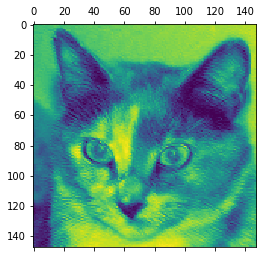

In [15]:
plt.matshow(first_layer_activation[0,:,:,4], cmap='viridis')

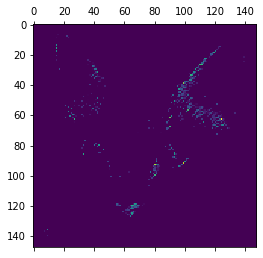

In [16]:
plt.matshow(first_layer_activation[0,:,:,7], cmap='viridis')

In [17]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

In [19]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    
    display_grid = np.zeros((size*n_cols, images_per_row*size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :,:,col*images_per_row + row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

/home/akshat/Documents/GHrepos/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


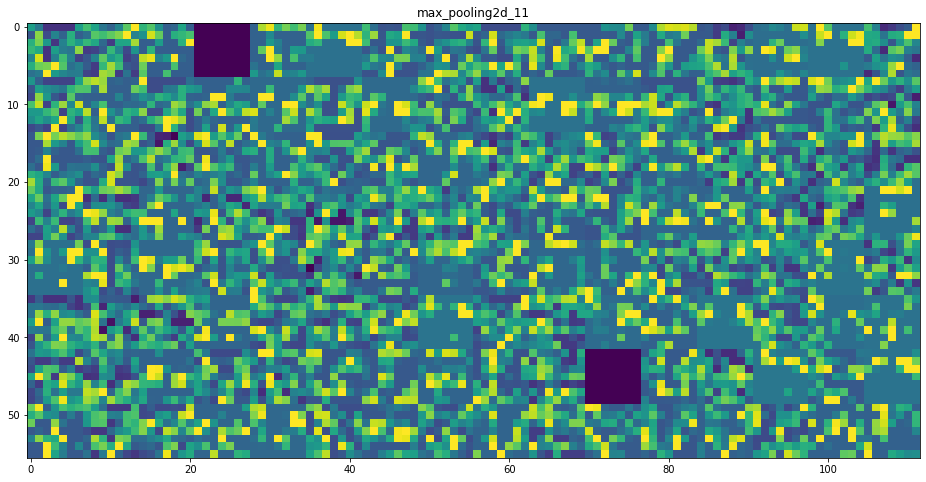

In [20]:
scale = 1./size

plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap = 'viridis')

Visualizing convnet filters

In [29]:
from keras.applications import VGG16
from keras import backend as K

In [30]:
model = VGG16(weights = 'imagenet', include_top=False)

58892288/58889256 [==============================] - 127s 2us/step


In [31]:
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, : , filter_index])

In [32]:
grads = K.gradients(loss, model.input)[0]

In [33]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [34]:
iterate = K.function([model.input], [loss, grads])

loss_value, grad_value = iterate([np.zeros((1, 150, 150, 3))])

In [36]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

In [38]:
step =1
for i in range(40):
    loss_value, grad_value = iterate([input_img_data])
    input_img_data += grad_value * step

In [39]:
def preprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x+= 0.5
    x = np.clip(x, 0, 1)
    
    x *=255
    x = np.clip(x, 0, 255).astype('uint8')
    return x